In [9]:
from cdsgd import DSClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score
import wittgenstein as lw
#pca
from sklearn.decomposition import PCA

In [10]:
gaussian = pd.read_csv('../data/gaussian_df.csv')
gaussian_labels = gaussian['labels']
gaussian = gaussian.drop(columns=['labels'])

Kmeans Silhouette Score: 0.6314108025017449 Number of Clusters: 2
DBSCAN Silhouette Score: 0.21477903309637697 Number of Clusters: 2
Agglomerative Silhouette Score: 0.6314707303920268 Number of Clusters: 2


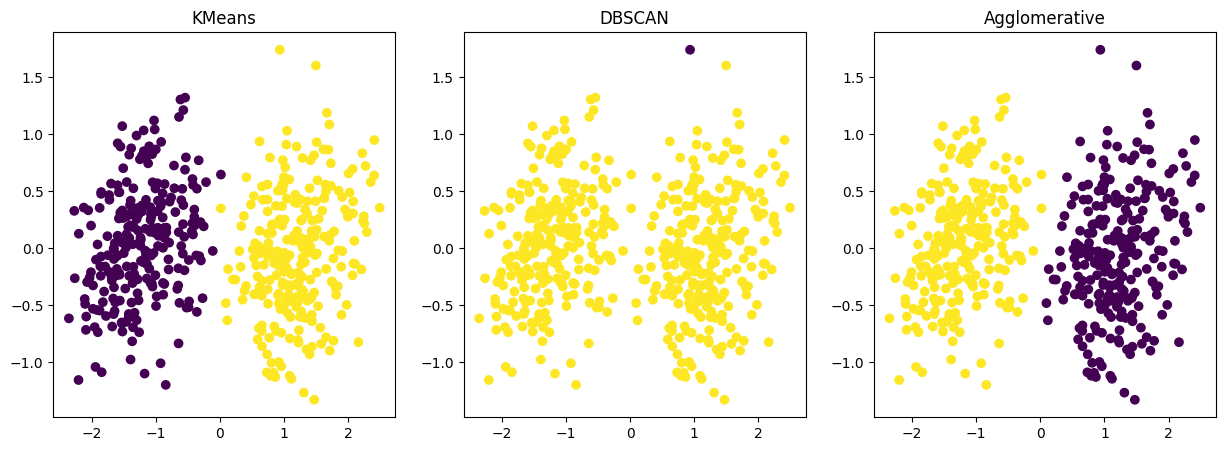

In [11]:
scaler = StandardScaler()
gaussian_scaled = scaler.fit_transform(gaussian)
gaussian = pd.DataFrame(gaussian_scaled, columns=gaussian.columns)
models = []
kmeans = KMeans(n_clusters=2)
kmeans_labels = kmeans.fit_predict(gaussian)
models.append({'model': kmeans, 'name': 'KMeans', 'labels': kmeans_labels})
print('Kmeans Silhouette Score:', silhouette_score(gaussian, kmeans_labels), "Number of Clusters:", len(np.unique(kmeans_labels)))

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(gaussian)
models.append({'model': dbscan, 'name': 'DBSCAN', 'labels': dbscan_labels})
if len(np.unique(dbscan_labels)) > 1:
    print('DBSCAN Silhouette Score:', silhouette_score(gaussian, dbscan_labels), "Number of Clusters:", len(np.unique(dbscan_labels)))
else:
    print('DBSCAN Silhouette Score: N/A', "Number of Clusters:", len(np.unique(dbscan_labels)))

agg = AgglomerativeClustering(n_clusters=2)
agg_labels = agg.fit_predict(gaussian)
models.append({'model': agg, 'name': 'Agglomerative', 'labels': agg_labels})
print('Agglomerative Silhouette Score:', silhouette_score(gaussian, agg_labels), "Number of Clusters:", len(np.unique(agg_labels)))

# visualize the clusters
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate(models):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(gaussian)
    ax[i].scatter(pca_result[:, 0], pca_result[:, 1], c=model['labels'], cmap='viridis')
    ax[i].set_title(model['name'])
plt.show()

## Lime

In [12]:
clustterToExplain = 1
i = 100 # instance to explain

#KMeans
y = (kmeans_labels == clustterToExplain).astype(int)
X_train, X_test, y_train, y_test = train_test_split(gaussian, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(gaussian, y)
print('KMeans Accuracy:', accuracy_score(y, clf.predict(gaussian)))
explainer = LimeTabularExplainer(gaussian.values, mode='classification', feature_names=gaussian.columns, class_names=['0', '1'], discretize_continuous=True)
exp = explainer.explain_instance(gaussian.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

#DBSCAN

#Agglomerative
y = (agg_labels == clustterToExplain).astype(int)
X_train, X_test, y_train, y_test = train_test_split(gaussian, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(gaussian, y)
print('Agglomerative Accuracy:', accuracy_score(y, clf.predict(gaussian)))
explainer = LimeTabularExplainer(gaussian.values, mode='classification', feature_names=gaussian.columns, class_names=['0', '1'], discretize_continuous=True)
exp = explainer.explain_instance(gaussian.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

KMeans Accuracy: 0.998


c:\Users\Daniel\Documents\GitHub\trabajo-dirigido\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Agglomerative Accuracy: 1.0


c:\Users\Daniel\Documents\GitHub\trabajo-dirigido\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Decision tree

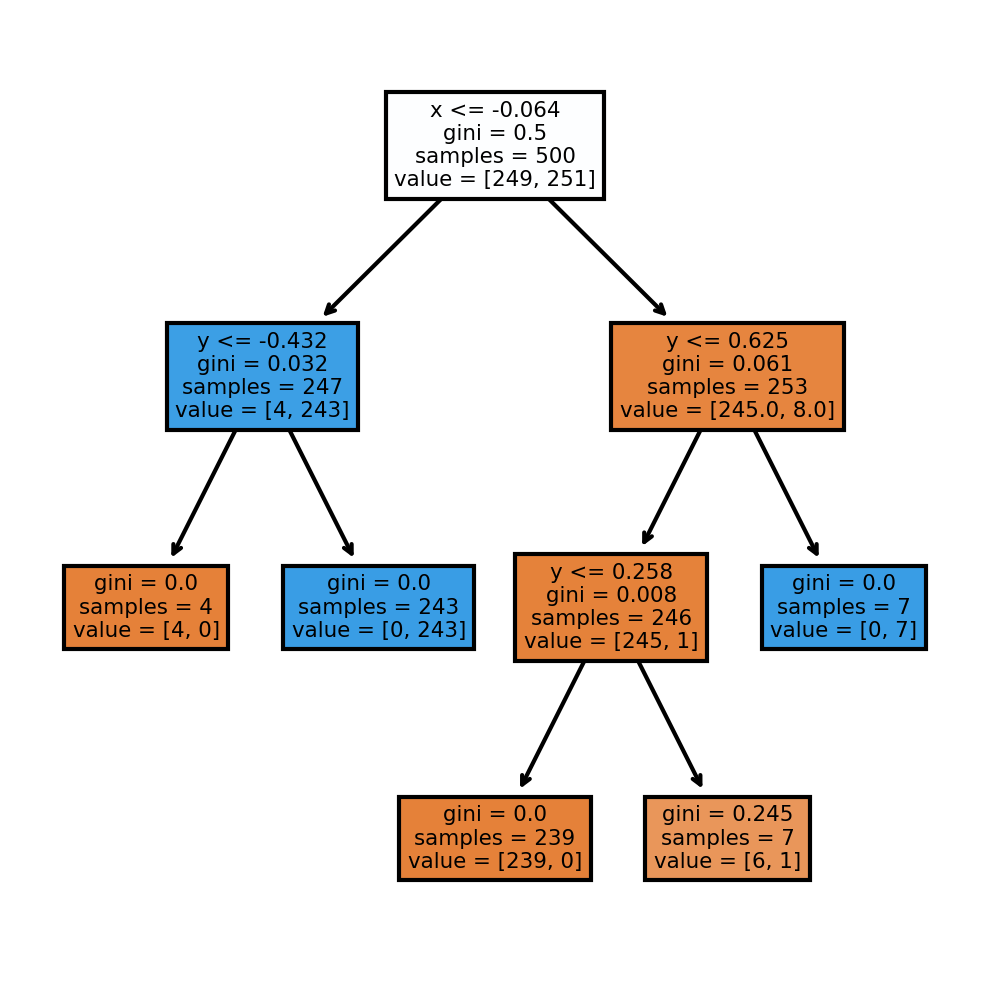

Decision Tree Accuracy: 0.998


In [13]:
# interpretamos con decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(gaussian, kmeans_labels)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=gaussian.columns)
plt.show()
y_pred = dt.predict(gaussian)
print('Decision Tree Accuracy:', accuracy_score(kmeans_labels, y_pred))


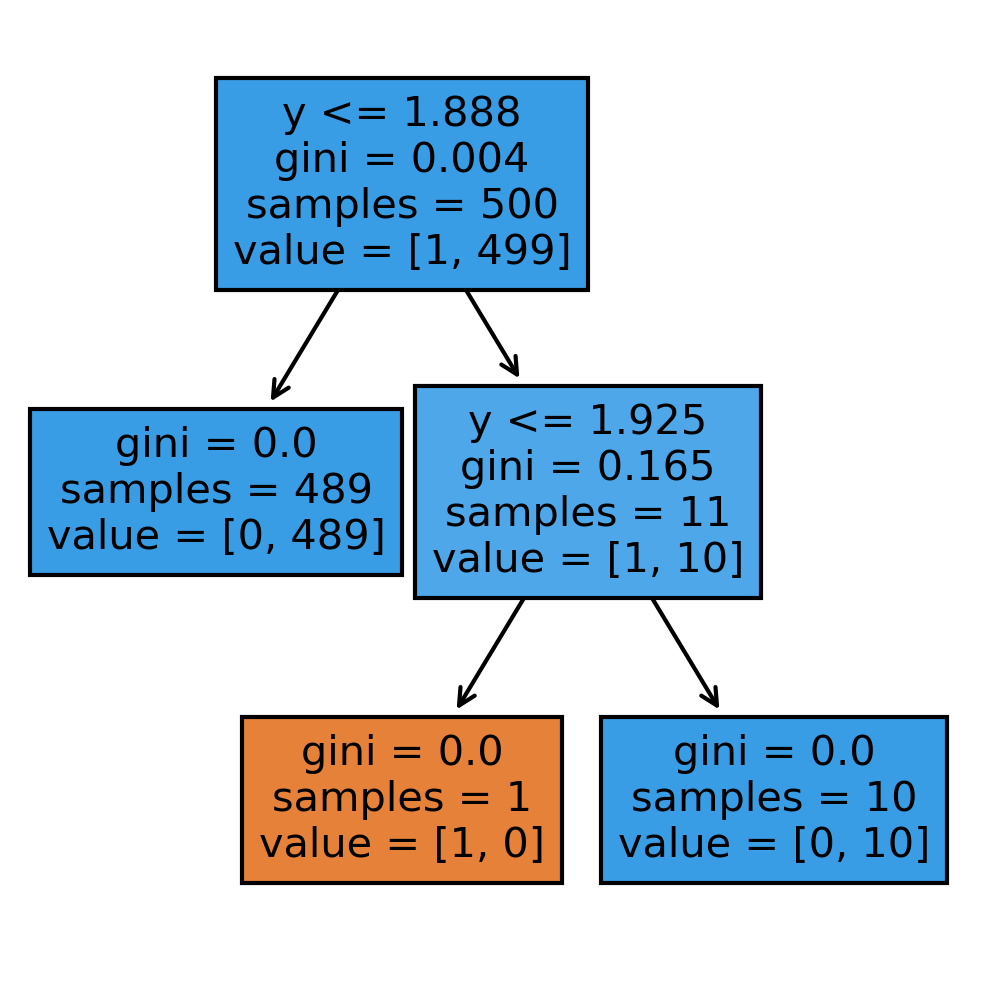

Decision Tree Accuracy: 1.0


In [14]:
# interpretamos con decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(gaussian, dbscan_labels)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=gaussian.columns)
plt.show()
y_pred = dt.predict(gaussian)
print('Decision Tree Accuracy:', accuracy_score(dbscan_labels, y_pred))

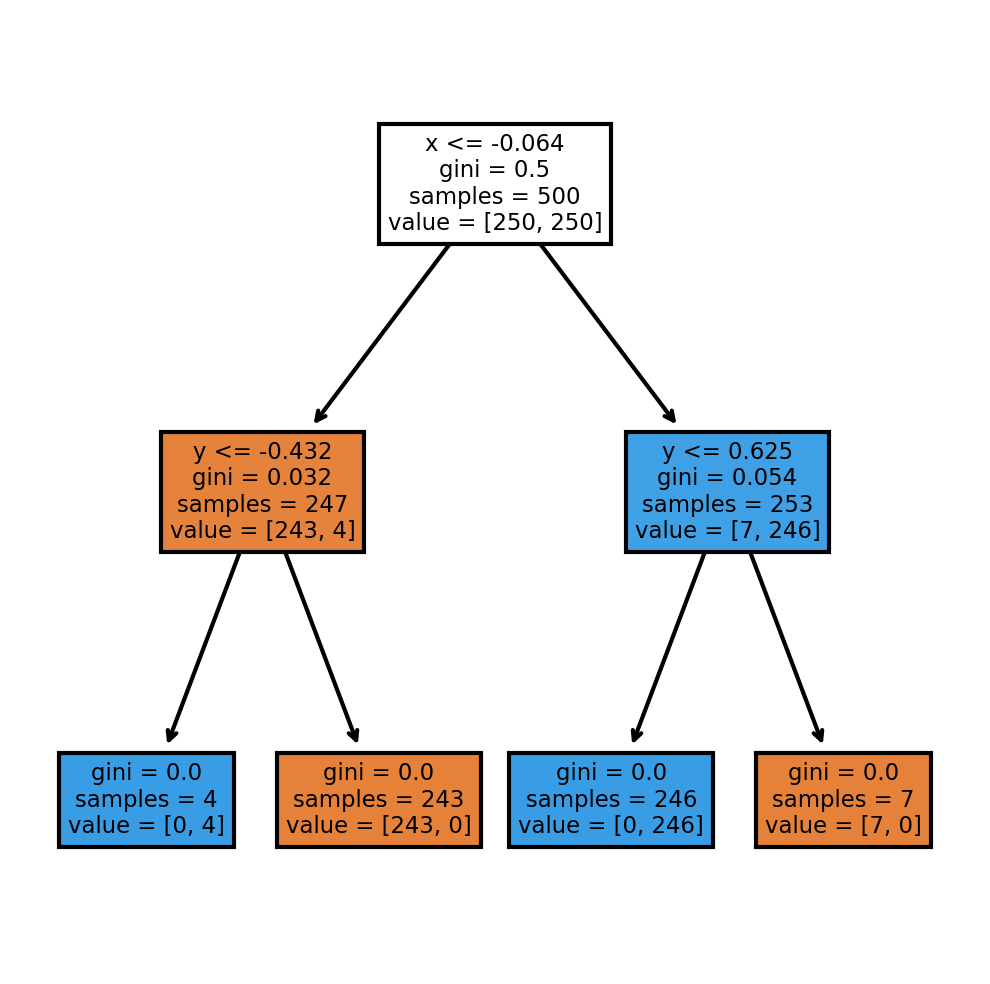

Decision Tree Accuracy: 1.0


In [15]:
# interpretamos con decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(gaussian, agg_labels)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=gaussian.columns)
plt.show()
y_pred = dt.predict(gaussian)
print('Decision Tree Accuracy:', accuracy_score(agg_labels, y_pred))

# RIPPER

In [16]:
pos = 1
# cambiamos las etiquetas para que el positivo sea el cluster 0
kmeans_labels_pos = (kmeans_labels == pos).astype(int)
dbscan_labels_pos = (dbscan_labels == pos).astype(int)
agg_labels_pos = (agg_labels == pos).astype(int)
# KMeans
ripper = lw.RIPPER()
df = pd.concat([gaussian, pd.DataFrame(kmeans_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(gaussian)
print('RIPPER Accuracy KMeans:', accuracy_score(kmeans_labels_pos, y_pred))
# DBSCAN
ripper = lw.RIPPER()
df = pd.concat([gaussian, pd.DataFrame(dbscan_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(gaussian)
print('RIPPER Accuracy DBSCAN:', accuracy_score(dbscan_labels_pos, y_pred))
# Agglomerative
ripper = lw.RIPPER()
df = pd.concat([gaussian, pd.DataFrame(agg_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(gaussian)
print('RIPPER Accuracy Agglomerative:', accuracy_score(agg_labels_pos, y_pred))

[[x=-1.03--0.77] V [x=<-1.31] V [x=-1.31--1.03] V [x=-0.77--0.48] V [x=-0.48--0.019^y=0.95-1.3] V [x=-0.48--0.019^y=0.36-0.62] V [x=-0.48--0.019^y=>1.3] V [x=-0.48--0.019^y=0.62-0.95] V [x=-0.48--0.019^y=-0.03-0.36] V [y=>1.3] V [x=-0.48--0.019^y=-0.31--0.03] V [y=0.62-0.95] V [y=0.95-1.3] V [y=-0.03-0.36^x=-0.019-0.55]]
RIPPER Accuracy KMeans: 1.0
[]
RIPPER Accuracy DBSCAN: 1.0
[[y=<-1.36] V [y=-0.67--0.31] V [y=-0.94--0.67] V [y=-1.36--0.94] V [y=-0.31--0.03^x=-0.019-0.55] V [x=>1.26] V [x=0.55-0.79] V [x=0.79-1.01] V [x=-0.019-0.55^y=0.36-0.62] V [x=1.01-1.26] V [x=-0.019-0.55^y=-0.03-0.36]]
RIPPER Accuracy Agglomerative: 0.996


ripper.py: .fit: RuntimeWarning: 
No positive samples. Existing target labels=[0].

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.



## DSClustering

Optimization started
Processing epoch	373	0.0005	

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Training time: 22.99s, epochs: 400

Least training loss reached: 0.000


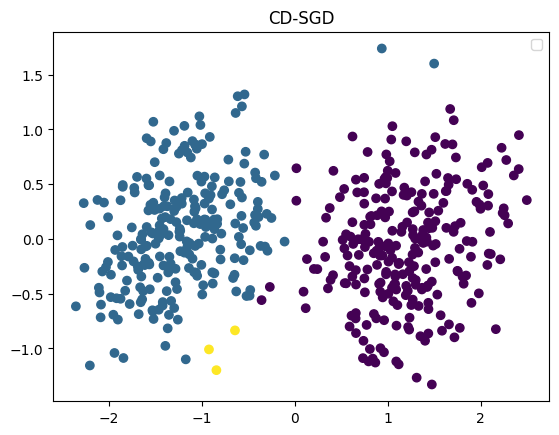

In [17]:
cdsgd = DSClustering(data=gaussian)
cdsgd.generate_categorical_rules()
cdsgd_labels = cdsgd.predict()
models.append({'model': cdsgd, 'name': 'CD-SGD', 'labels': cdsgd_labels})
#vvisualize the clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(gaussian)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cdsgd_labels, cmap='viridis')
plt.title('CD-SGD')
plt.legend()
plt.show()

In [18]:
cdsgd.print_most_important_rules()



Most important rules for Cluster 0

	[0.499] R11: -0.697 < x < -0.033
			0: 0.423	1: 0.000	2: 0.000	3: 0.164	Unc: 0.412

	[0.463] R10: x < -0.697
			0: 0.463	1: 0.000	2: 0.000	3: 0.000	Unc: 0.537

	[0.430] R17: y > 0.657
			0: 0.430	1: 0.000	2: 0.000	3: 0.000	Unc: 0.570

	[0.365] R27: Positive x - -0.033, y - 0.015
			0: 0.314	1: 0.011	2: 0.000	3: 0.099	Unc: 0.576

	[0.356] R16: 0.015 < y < 0.657
			0: 0.355	1: 0.001	2: 0.000	3: 0.000	Unc: 0.644

	[0.343] R28: Negative x - -0.033, y - 0.015
			0: 0.243	1: 0.242	2: 0.000	3: 0.000	Unc: 0.515

Most important rules for Cluster 1

	[0.475] R12: -0.033 < x < 0.631
			0: 0.000	1: 0.475	2: 0.000	3: 0.000	Unc: 0.525

	[0.472] R13: x > 0.631
			0: 0.000	1: 0.472	2: 0.000	3: 0.000	Unc: 0.528

	[0.379] R14: y < -0.627
			0: 0.000	1: 0.366	2: 0.000	3: 0.026	Unc: 0.607

	[0.350] R15: -0.627 < y < 0.015
			0: 0.000	1: 0.350	2: 0.000	3: 0.000	Unc: 0.650

	[0.342] R28: Negative x - -0.033, y - 0.015
			0: 0.243	1: 0.242	2: 0.000	3: 0.000	Unc: 0.515



c:\Users\Daniel\Documents\GitHub\trabajo-dirigido\env\Lib\site-packages\cdsgd\ClusteringSelector.py:248: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  row_modes[0][x] = self.get_best_labels()[x]


Optimization started
Processing epoch	63	0.0253	

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing epoch	94	0.0090	
Training time: 5.54s, epochs: 95

Least training loss reached: 0.009


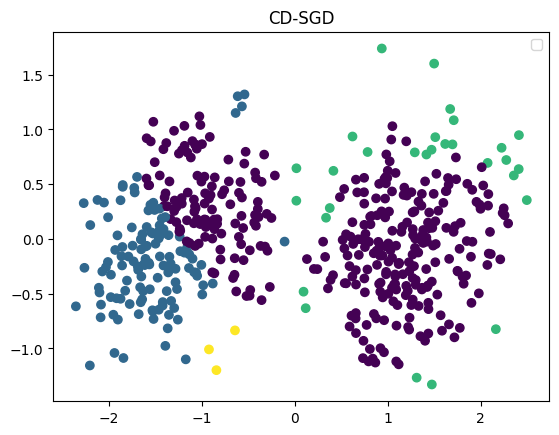

In [19]:
cdsgd = DSClustering(data=gaussian, most_voted=True)
cdsgd.generate_categorical_rules()
cdsgd_labels = cdsgd.predict()
models.append({'model': cdsgd, 'name': 'CD-SGD más votado', 'labels': cdsgd_labels})
#vvisualize the clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(gaussian)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cdsgd_labels, cmap='viridis')
plt.title('CD-SGD')
plt.legend()
plt.show()

In [20]:
cdsgd.print_most_important_rules()



Most important rules for Cluster 0

	[0.411] R27: Positive x - -0.033, y - 0.015
			0: 0.237	1: 0.000	2: 0.257	3: 0.220	Unc: 0.286

	[0.287] R12: -0.033 < x < 0.631
			0: 0.189	1: 0.246	2: 0.000	3: 0.000	Unc: 0.564

	[0.282] R15: -0.627 < y < 0.015
			0: 0.272	1: 0.000	2: 0.020	3: 0.000	Unc: 0.708

	[0.240] R13: x > 0.631
			0: 0.136	1: 0.287	2: 0.000	3: 0.000	Unc: 0.577

	[0.223] R16: 0.015 < y < 0.657
			0: 0.223	1: 0.000	2: 0.000	3: 0.000	Unc: 0.777

	[0.206] R28: Negative x - -0.033, y - 0.015
			0: 0.148	1: 0.128	2: 0.011	3: 0.000	Unc: 0.713

	[0.205] R10: x < -0.697
			0: 0.205	1: 0.000	2: 0.000	3: 0.000	Unc: 0.795

Most important rules for Cluster 1

	[0.349] R13: x > 0.631
			0: 0.136	1: 0.287	2: 0.000	3: 0.000	Unc: 0.577

	[0.328] R12: -0.033 < x < 0.631
			0: 0.189	1: 0.246	2: 0.000	3: 0.000	Unc: 0.564

	[0.315] R14: y < -0.627
			0: 0.000	1: 0.299	2: 0.000	3: 0.032	Unc: 0.669

Most important rules for Cluster 2

	[0.428] R27: Positive x - -0.033, y - 0.015
			0: 0.237	1: 0

Optimization started
Processing epoch	373	0.0011	

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Training time: 22.61s, epochs: 400

Least training loss reached: 0.001


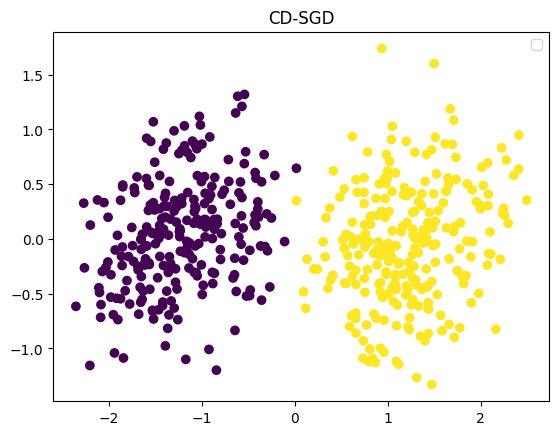

In [21]:
cdsgd = DSClustering(data=gaussian,cluster=2)
cdsgd.generate_categorical_rules()
cdsgd_labels = cdsgd.predict()
models.append({'model': cdsgd, 'name': 'CD-SGD con 2 clusters', 'labels': cdsgd_labels})
#vvisualize the clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(gaussian)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cdsgd_labels, cmap='viridis')
plt.title('CD-SGD')
plt.legend()
plt.show()

In [22]:
cdsgd.print_most_important_rules()



Most important rules for Cluster 0

	[0.506] R11: y < -0.627
			0: 0.506	1: 0.000	Unc: 0.494

	[0.453] R10: x > 0.631
			0: 0.453	1: 0.000	Unc: 0.547

	[0.379] R12: -0.627 < y < 0.015
			0: 0.379	1: 0.000	Unc: 0.621

	[0.361] R9: -0.033 < x < 0.631
			0: 0.361	1: 0.000	Unc: 0.639

Most important rules for Cluster 1

	[0.500] R14: y > 0.657
			0: 0.000	1: 0.500	Unc: 0.500

	[0.370] R7: x < -0.697
			0: 0.000	1: 0.370	Unc: 0.630

	[0.353] R8: -0.697 < x < -0.033
			0: 0.000	1: 0.353	Unc: 0.647

	[0.289] R13: 0.015 < y < 0.657
			0: 0.000	1: 0.289	Unc: 0.711


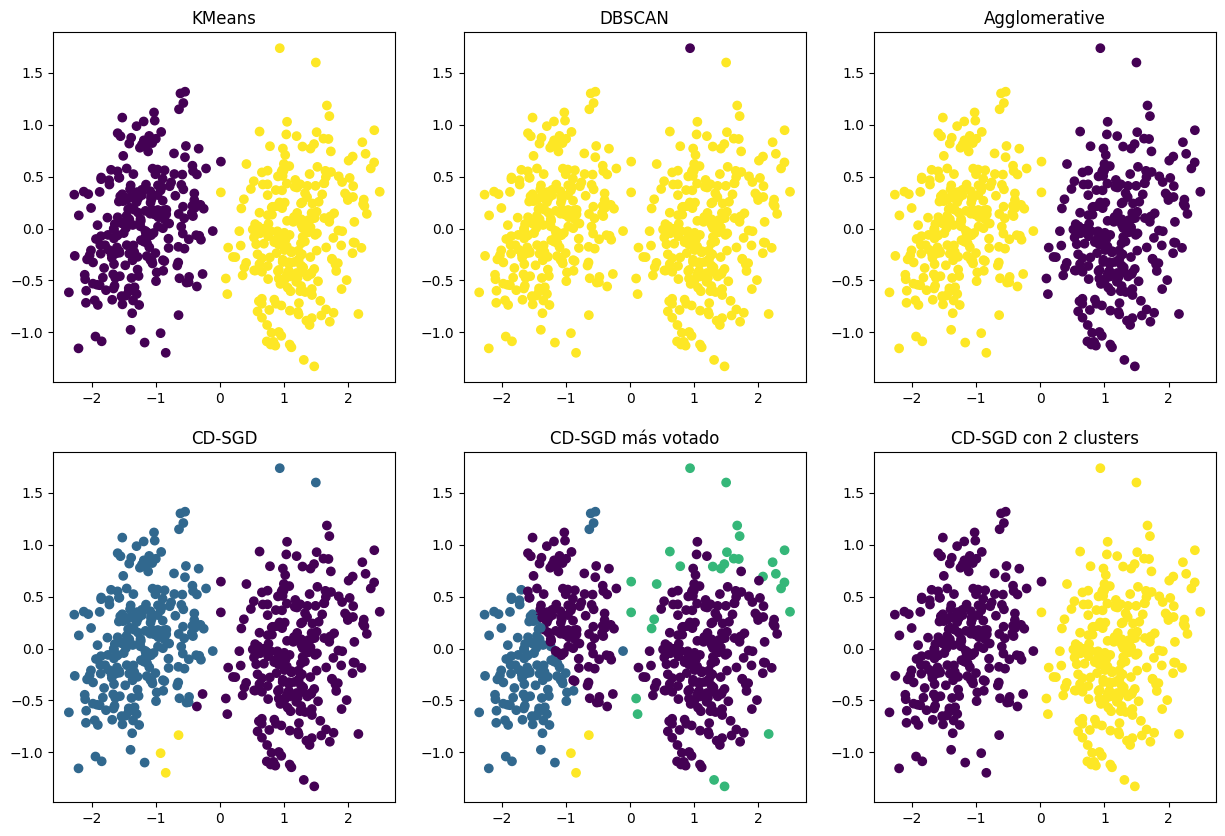

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, model in enumerate(models):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(gaussian)
    ax[i//3, i%3].scatter(pca_result[:, 0], pca_result[:, 1], c=model['labels'], cmap='viridis')
    ax[i//3, i%3].title.set_text(model['name'])
plt.show()